In [11]:
import tensorflow as tf
import os
import imghdr
import numpy as np
from matplotlib import pyplot as plt

In [9]:
!pip install opencv-python

     ---------------------------------------- 38.2/38.2 MB 9.8 MB/s eta 0:00:00


You should consider upgrading via the 'C:\Users\kaurg\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [10]:
import cv2

In [12]:
data_dir = r'C:\Users\kaurg\Downloads\archive (1)\cell_images\cell_images'
image_exts = ['jpeg','jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

Image not in ext list C:\Users\kaurg\Downloads\archive (1)\cell_images\cell_images\Parasitized\Thumbs.db
Image not in ext list C:\Users\kaurg\Downloads\archive (1)\cell_images\cell_images\Uninfected\Thumbs.db


In [13]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

Found 27558 files belonging to 2 classes.


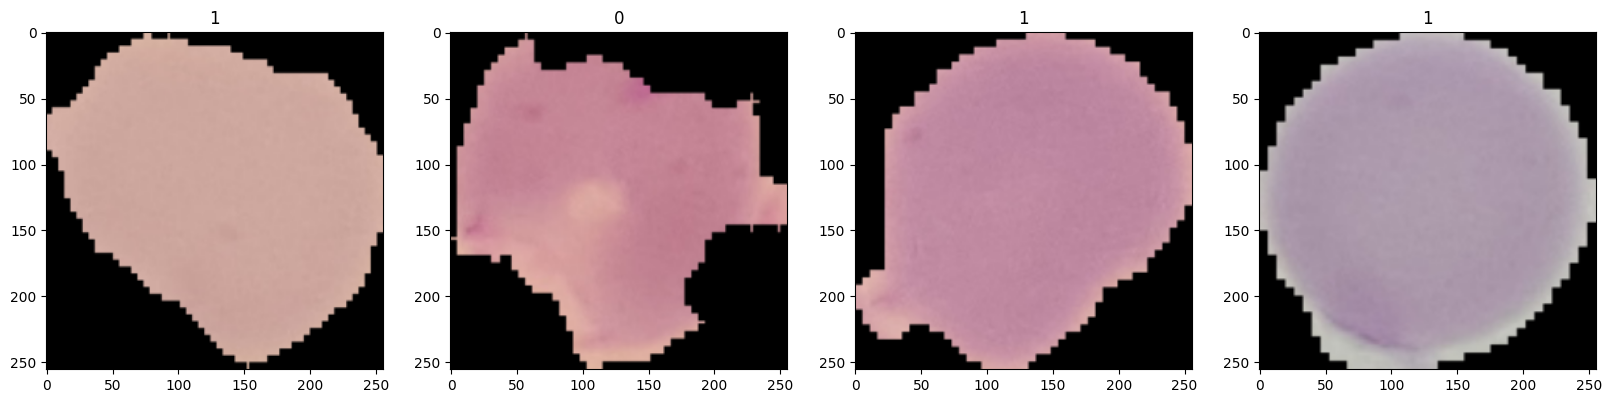

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [15]:
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()

train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [17]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [23]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=2, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/2
603/603 [==============================] - 579s 960ms/step - loss: 0.1526 - accuracy: 0.9485 - val_loss: 0.1880 - val_accuracy: 0.9402
Epoch 2/2
603/603 [==============================] - 587s 972ms/step - loss: 0.1257 - accuracy: 0.9582 - val_loss: 0.1614 - val_accuracy: 0.9535


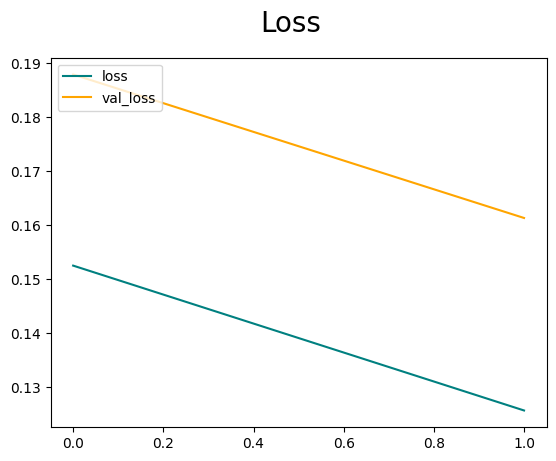

In [24]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

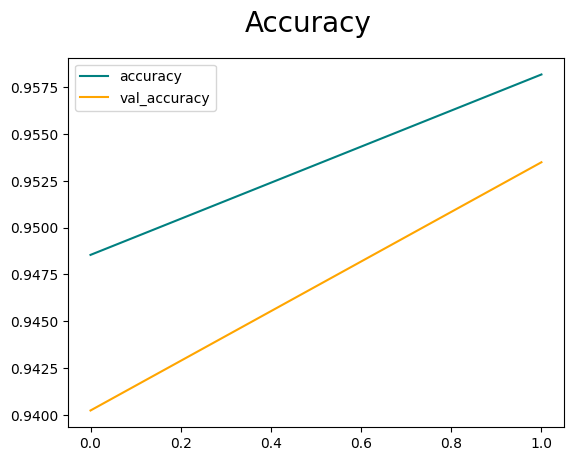

In [25]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [26]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
print(pre.result(), re.result(), acc.result())

1/1 [==============================] - 0s 257ms/step
tf.Tensor(0.95702004, shape=(), dtype=float32) tf.Tensor(0.95156693, shape=(), dtype=float32) tf.Tensor(0.95348835, shape=(), dtype=float32)


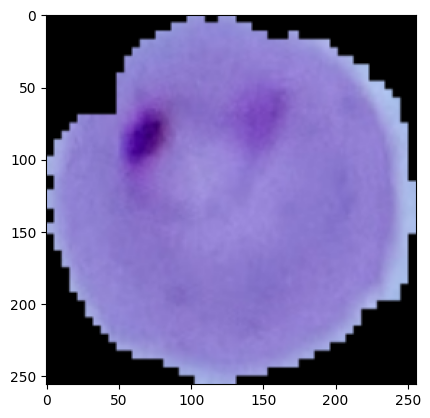

In [41]:
import cv2

img = cv2.imread(r"C:\Users\kaurg\Downloads\archive (1)\cell_images\cell_images\Parasitized\C37BP2_thinF_IMG_20150620_131423a_cell_93.png")
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))

In [42]:
yhat = model.predict(np.expand_dims(resize/255, 0))

if yhat > 0.5: 
    print(f'Predicted class is Parasitized')
else:
    print(f'Predicted class is Normal')

1/1 [==============================] - 0s 28ms/step
Predicted class is Parasitized
